# Feedback Effectiveness Prize PyTorch TPU starter - DeBERTa-v3-large (training)
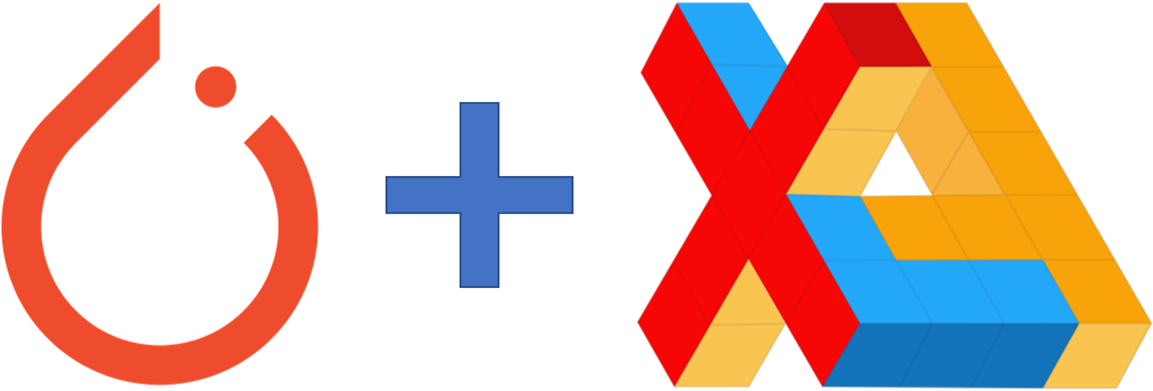

#### If you found this helpful, please give it an upvote!

# Introduction
PyTorch XLA is a PyTorch library for XLA support. XLA (Accelerated Linear Algebra) is a domain-specific compiler that was originally meant for compiling and accelerating TensorFlow models. However, other packages, like JAX and now PyTorch XLA can compile program with XLA to accelerate code. TPUs can be programmed with XLA programs and PyTorch XLA provides this interface with TPUs by compiling our PyTorch code as XLA programs to run on TPU devices.

In this kernel, I provide an in-depth look into how you can use PyTorch XLA to train a PyTorch model on the TPU for the Feedback Effectiveness Prize competition.


# Installs & Imports

The below cell will install the PyTorch XLA package. We will use version 1.11 of the package:

In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModel,AutoTokenizer,AutoConfig,AutoModelForTokenClassification
from transformers import AdamW, get_cosine_schedule_with_warmup
import datasets
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.metrics import log_loss
from pathlib import Path
import torch.nn.functional as F
import os
import gc
from joblib import Parallel, delayed
import joblib
import torch.nn as nn
import warnings
import time
from sklearn.metrics import log_loss
from tqdm.auto import tqdm
import re
# PyTorch XLA-specific imports
gc.enable()

In [2]:
transformers.__version__

'4.20.1'

In [3]:
import transformers
transformers.logging.set_verbosity_error()

In [4]:
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

Now let's define the necessary functions and variables needed for training.

These are some hyperparameters for training. When you fork (after you upvote of course, ;) ), feel free to play around with these hyperparameters!

## Dataset creation

The best approach to speed up dataloading is to create the preprocessed dataset, and even better to save RAM resources is if it's memory-mapped. We can do both with HuggingFace Datasets. I have taken the code from my previous notebook [here](https://www.kaggle.com/code/tanlikesmath/feedback-prize-effectiveness-eda-deberta-baseline).

In [5]:
class CFG:
    batch_size=8
    num_workers=2
    samples_input = '../input/feedback-prize-effectiveness/test.csv'
    seed = 43
    max_len=1800
    checkpoints = '../input/deberta-v1-token-classifier'

In [6]:
models = {
        
    'deberta_v3':{
        'model':'../input/deberta-v3-large/deberta-v3-large',
        'checkpoints':'../input/deberta-v3-token-classifier',
        'tokens_resized':128015
    },
    
    'deberta_v1':{
        'model':'../input/debertalarge',
        'checkpoints':'../input/deberta-v1-token-classifier',
        'tokens_resized':50279
    },
    
}

In [7]:
disc_types = [
    "Claim",
    "Concluding Statement",
    "Counterclaim",
    "Evidence",
    "Lead",
    "Position",
    "Rebuttal",
]
cls_tokens_map = {label: f"[CLS_{label.upper()}]" for label in disc_types}
end_tokens_map = {label: f"[END_{label.upper()}]" for label in disc_types}

label2id = {"Ineffective": 0, "Adequate": 1, "Effective": 2}

In [8]:
os.environ['TOKENIZERS_PARALLELISM'] = '1'

In [9]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(CFG.seed)

In [10]:
def find_positions(example):

    text = example["text"][0]
    
    # keeps track of what has already
    # been located
    min_idx = 0
    
    # stores start and end indexes of discourse_texts
    idxs = []
    
    for dt in example["discourse_text"]:
        # calling strip is essential
        matches = list(re.finditer(re.escape(dt.strip()), text))
        
        # If there are multiple matches, take the first one
        # that is past the previous discourse texts.
        if len(matches) > 1:
            for m in matches:
                if m.start() >= min_idx:
                    break
        # If no matches are found
        elif len(matches) == 0:
            idxs.append([-1]) # will filter out later
            continue  
        # If one match is found
        else:
            m = matches[0]
            
        idxs.append([m.start(), m.end()])

        min_idx = m.start()

    return idxs

def tokenize(example,tokenizer,cls_id_map):
    example["idxs"] = find_positions(example)

    text = example["text"][0]
    chunks = []
    ids_idxs = []
    prev = 0

    zipped = zip(
        example["idxs"],
        example["discourse_type"],
        example['discourse_id']
    )
    for idxs, disc_type, disc_id in zipped:
        # when the discourse_text wasn't found
        if idxs == [-1]:
            continue

        s, e = idxs

        # if the start of the current discourse_text is not 
        # at the end of the previous one.
        # (text in between discourse_texts)
        if s != prev:
            chunks.append(text[prev:s])
            prev = s

        # if the start of the current discourse_text is 
        # the same as the end of the previous discourse_text
        if s == prev:
            chunks.append(cls_tokens_map[disc_type])
            chunks.append(text[s:e])
            chunks.append(end_tokens_map[disc_type])
        
        prev = e

        ids_idxs.append( [disc_id,0] )

    tokenized = tokenizer(
        " ".join(chunks),
        padding=False,
        truncation=True,
        max_length=CFG.max_len,
        add_special_tokens=True,
    )
    
    # at this point, labels is not the same shape as input_ids.
    # The following loop will add -100 so that the loss function
    # ignores all tokens except CLS tokens

    # idx for labels list
    idx = 0
    for i,id_ in enumerate( tokenized["input_ids"] ):
        # if this id belongs to a CLS token
        if id_ in cls_id_map.values():
            ids_idxs[idx][1] = i
            idx += 1
    
    tokenized['len'] = sum( tokenized['attention_mask'] )
    tokenized['essay_id'] = example.name
    tokenized['ids_idxs'] = ids_idxs
    

    return tokenized
def training_data_helper( df, ids, tokenizer, cls_id_map ):
    
    results = []
    for id_ in ids:
        results.append(  tokenize( df.loc[id_], tokenizer, cls_id_map ) )
    return results
    
def training_data( df, tokenizer,cls_id_map ):
    
    idxs = np.array_split( df.index.values, CFG.num_workers )
    
    results = Parallel(n_jobs=CFG.num_workers)( delayed( training_data_helper )( df, ids, tokenizer, cls_id_map ) for ids in idxs )
    
    final_results = []
    
    for result in results:
        final_results.extend( result )
    
    return final_results
    
    
def read_file(x):
    return open(x,'r').read()


In [11]:
df = pd.read_csv('../input/feedback-prize-effectiveness/test.csv')
df['text'] = df.essay_id.apply( lambda x: read_file(f'../input/feedback-prize-effectiveness/test/{x}.txt') )
grouped_df = df.groupby('essay_id').agg(list)

In [12]:
class FeedbackDataset:
    def __init__(self, samples ):
        self.samples = samples
        

    def __len__(self):
        return len( self.samples )

    def __getitem__(self, idx):
        
        return {
            'ids': self.samples[idx]['input_ids'],
            'mask': self.samples[idx]['attention_mask'],
            'essay_id':self.samples[idx]['essay_id'],
            'ids_idxs':self.samples[idx]['ids_idxs'],
        }

In [13]:
class Collate:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        output = dict()
        output["ids"] = [sample["ids"] for sample in batch]
        output["mask"] = [sample["mask"] for sample in batch]
        output['essay_id'] = [sample["essay_id"] for sample in batch]
        output['ids_idxs'] = [sample["ids_idxs"] for sample in batch]

        # calculate max token length of this batch
        batch_max = max([len(ids) for ids in output["ids"]])

        # add padding
        if self.tokenizer.padding_side == "right":
            output["ids"] = [s + (batch_max - len(s)) * [self.tokenizer.pad_token_id] for s in output["ids"]]
            output["mask"] = [s + (batch_max - len(s)) * [0] for s in output["mask"]]
            
        else:
            output["ids"] = [(batch_max - len(s)) * [self.tokenizer.pad_token_id] + s for s in output["ids"]]
            output["mask"] = [(batch_max - len(s)) * [0] + s for s in output["mask"]]

        # convert to tensors
        
        
        
        output["ids"] = torch.tensor(output["ids"], dtype=torch.long)
        output["mask"] = torch.tensor(output["mask"], dtype=torch.long)

        return output

# Training code

Let's start training! To do so, we start by initializing the model. We use the `xmp.MpModelWrapper` provided by PyTorch XLA to save memory when initializing the model.

In [14]:
class FeedbackModel3(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        
        self.model_name = model_name

        hidden_dropout_prob: float = 0
        layer_norm_eps: float = 1e-7

        config = AutoConfig.from_pretrained(model_name)

        config.update(
            {
                "output_hidden_states": False,
                "hidden_dropout_prob": hidden_dropout_prob,
                "layer_norm_eps": layer_norm_eps,
                "add_pooling_layer": False,
            }
        )
        
        self.config = config
        self.transformer = AutoModel.from_pretrained(model_name, config=config)
        self.output = nn.Linear(config.hidden_size, 3)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, ids, mask):

        logits = self.transformer( input_ids=ids, attention_mask=mask ).last_hidden_state
        logits = self.output( logits ) 
        logits = self.softmax( logits )
    
        return logits

Let's now define our training and validation functions.

In [15]:
def eval_loop_fn(data_loader, model, device):
    
    preds = []
    essay_ids = []
    ids_idxs = []
      
    for d in tqdm( data_loader, desc='[EVAL]' ): # enumerate through dataloader

        # put tensors onto desired device, in this case the TPU core
        
        d['ids'] = d['ids'].to(device)
        d['mask'] = d['mask'].to(device)
            
        # pass ids to model
        with torch.no_grad(): 
            with torch.cuda.amp.autocast(enabled=True):
                outputs =  model(d['ids'],d['mask'])

        # Add the outputs and targets to a list 
        preds.extend( outputs.cpu().numpy().tolist() )
        essay_ids.extend( d['essay_id'] )
        ids_idxs.extend( d['ids_idxs'] )
    
    
    return ( preds , essay_ids, ids_idxs )


Finally, we define a main function that we will run on each of the 8 cores of the TPU.

In [16]:
cols = ['discourse_id','Ineffective','Adequate','Effective']

In [17]:
def get_preds( checkpoint, data_loader, device, model, tokens_resized ):
        
    model = FeedbackModel3(model)
    model.transformer.resize_token_embeddings( tokens_resized )
    model.load_state_dict( torch.load(checkpoint) )
    model.to(device)
    model.eval()
    
    preds, essay_ids, ids_idxs = eval_loop_fn( data_loader, model, device )
    
    final_preds = []
    
    for pred, eid, discourse_ids in zip( preds, essay_ids, ids_idxs ):
        
        for did, idx in discourse_ids:

            final_preds.append( [ did ] +  pred[idx] )
    
    del model
    gc.collect()
    
    return pd.DataFrame( final_preds, columns=cols )
        
    
    

In [18]:
def main( model, checkpoints, tokens_resized ):
    
    tokenizer = AutoTokenizer.from_pretrained(model)
    tokenizer.add_special_tokens(
        {"additional_special_tokens": list(cls_tokens_map.values())+list(end_tokens_map.values())}
    )
    
    cls_id_map = {
    label: tokenizer.encode(tkn)[1]
    for label, tkn in cls_tokens_map.items()
    }
    
    collate_fn = Collate(tokenizer)
    
    all_samples = training_data(grouped_df,tokenizer,cls_id_map)
    
    all_samples = sorted( all_samples, key=lambda x : len(x['input_ids']))
    
    dataset = FeedbackDataset( all_samples )
    
    data_loader = DataLoader( dataset, batch_size=CFG.batch_size, pin_memory=True, num_workers=CFG.num_workers, collate_fn=collate_fn )
    
    device = torch.device('cuda:0')
    
    ans = []
    
    print(f'Model : {model}')
    k=0
    for chkpoint in os.listdir( checkpoints ):
        print(f'Fold {k} Inferring...')
        ans.append( get_preds( os.path.join( checkpoints,chkpoint ), data_loader, device, model, tokens_resized ) )
        k += 1
    print('All Folds Done !.')
    
    
    submission = pd.DataFrame()

    index = ans[0].discourse_id

    submission['discourse_id'] = index
    submission['Ineffective'] = np.mean( [ a.set_index('discourse_id').loc[index,'Ineffective'].values for a in ans ], axis=0 )
    submission['Adequate'] = np.mean( [ a.set_index('discourse_id').loc[index,'Adequate'].values for a in ans ], axis=0 )
    submission['Effective'] = np.mean( [ a.set_index('discourse_id').loc[index,'Effective'].values for a in ans ], axis=0 )
    
    return submission
        

We need to set some environment variables before training, such as using faster bfloat16 training, dealing with HuggingFace tokenizer parallelism warning, etc.

In [19]:
ans = []

In [20]:
for keys,vals in models.items():
    print(f'[EVAL] Model : {keys}')
    ans.append( main( **vals ) )

[EVAL] Model : deberta_v3
Model : ../input/deberta-v3-large/deberta-v3-large
Fold 0 Inferring...


[EVAL]:   0%|          | 0/1 [00:00<?, ?it/s]

Exception ignored in: <function _ConnectionBase.__del__ at 0x7feeb7c97ef0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Fold 1 Inferring...


[EVAL]:   0%|          | 0/1 [00:00<?, ?it/s]

Fold 2 Inferring...


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 263, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times



[EVAL]:   0%|          | 0/1 [00:00<?, ?it/s]

Fold 3 Inferring...


[EVAL]:   0%|          | 0/1 [00:00<?, ?it/s]

Exception ignored in: <function _ConnectionBase.__del__ at 0x7feeb7c97ef0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


All Folds Done !.
[EVAL] Model : deberta_v1
Model : ../input/debertalarge
Fold 0 Inferring...


[EVAL]:   0%|          | 0/1 [00:00<?, ?it/s]

Fold 1 Inferring...


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 263, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times



[EVAL]:   0%|          | 0/1 [00:00<?, ?it/s]

Exception ignored in: <function _ConnectionBase.__del__ at 0x7feeb7c97ef0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Fold 2 Inferring...


[EVAL]:   0%|          | 0/1 [00:00<?, ?it/s]

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 263, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times



Fold 3 Inferring...


[EVAL]:   0%|          | 0/1 [00:00<?, ?it/s]

All Folds Done !.


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 263, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times



In [21]:
submission = pd.DataFrame()

index = ans[0].discourse_id

submission['discourse_id'] = index
submission['Ineffective'] = np.mean( [ a.set_index('discourse_id').loc[index,'Ineffective'].values for a in ans ], axis=0 )
submission['Adequate'] = np.mean( [ a.set_index('discourse_id').loc[index,'Adequate'].values for a in ans ], axis=0 )
submission['Effective'] = np.mean( [ a.set_index('discourse_id').loc[index,'Effective'].values for a in ans ], axis=0 )

In [22]:
submission_2 = submission.copy()

In [23]:
submission_2

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.028063,0.380401,0.591536
1,5a88900e7dc1,0.030081,0.661738,0.308181
2,9790d835736b,0.049183,0.582257,0.368560
3,75ce6d68b67b,0.078688,0.584266,0.337046
4,93578d946723,0.082108,0.535329,0.382562
5,2e214524dbe3,0.015990,0.329984,0.654026
6,84812fc2ab9f,0.020073,0.315199,0.664728
7,c668ff840720,0.074962,0.627167,0.297871
8,739a6d00f44a,0.098521,0.500285,0.401195
9,bcfae2c9a244,0.018203,0.590748,0.391049


In [24]:
from functools import partial

In [25]:
class CustomModel(nn.Module):
    def __init__(self, model_name ):
        super().__init__()
       
        self.config = AutoConfig.from_pretrained(model_name, output_hidden_states=False)
        
        self.bilstm = nn.LSTM(self.config.hidden_size, (self.config.hidden_size) // 2, num_layers=2, 
                              dropout=self.config.hidden_dropout_prob, batch_first=True,
                              bidirectional=True)
   
        
        self.model = AutoModel.from_pretrained(model_name, config=self.config)
        
        # gradient checkpointing

        self.output = nn.Sequential(
            nn.Linear(self.config.hidden_size, 3)
            # nn.Linear(256, self.cfg.target_size)
        )
        

    def forward(self, ids, mask, token_type_ids=None, targets=None):
        if token_type_ids:
            transformer_out = self.model(ids, mask, token_type_ids)
        else:
            transformer_out = self.model(ids, mask)
        
        # LSTM/GRU header
#         all_hidden_states = torch.stack(transformer_out[1])
#         sequence_output = self.pooler(all_hidden_states)
        
        # simple CLS
        sequence_output = transformer_out[0][:, 0, :]

        
        # Main task
        logits1 = self.output(sequence_output)
        
        return logits1

In [26]:
class FeedBackModel(nn.Module):
    def __init__(self, model_name):
        super(FeedBackModel, self).__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        config = self.config
        config.update({
            "output_hidden_states": True
        })
        self.model = AutoModel.from_pretrained(model_name, config=config)
        self.fc = nn.Linear(config.hidden_size, 3)
#         if CFG.freezing:
#             freeze(self.model.embeddings)
#             freeze(self.model.encoder.layer[:12])

    def forward(self, ids, mask):
        out = self.model(input_ids=ids, attention_mask=mask)
        all_hidden_states = torch.stack(out.hidden_states)
        layer_index = 20
        cls_embeddings = all_hidden_states[layer_index + 1, :, 0]
        outputs = self.fc(cls_embeddings)
        return outputs


In [27]:
class FeedbackModel2(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        
        self.model_name = model_name

        hidden_dropout_prob: float = 0
        layer_norm_eps: float = 1e-7

        config = AutoConfig.from_pretrained(model_name)

        config.update(
            {
                "output_hidden_states": False,
                "hidden_dropout_prob": hidden_dropout_prob,
                "layer_norm_eps": layer_norm_eps,
                "add_pooling_layer": False,
                "num_labels": 3,
            }
        )
        
        self.config = config
        
        self.transformer = AutoModel.from_pretrained(model_name, config=config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
      
        self.output = nn.Linear(config.hidden_size, 3)

    def forward(self, ids, mask, token_type_ids=None, targets=None):
        
        if token_type_ids is not None:
            transformer_out = self.transformer( ids, mask, token_type_ids )
        else:
            transformer_out = self.transformer(ids, mask)
        sequence_output = transformer_out.last_hidden_state[:,0,:]
#         sequence_output = self.pooler( sequence_output, mask )
#         sequence_output = self.dropout( sequence_output )

        logits1 = self.output( self.dropout( sequence_output ) )


  
        return logits1


In [28]:
model_grps = {
    
       'deberta_v3_768':{
        'arch': partial( FeedbackModel2, model_name='../input/deberta-v3-large/deberta-v3-large'),
        'tokenizer_path': '../input/deberta-v3-large/deberta-v3-large',
        'checkpoints':[
           '../input/deberta-v3-768/xla_trained_model_fold_0 (1).pth',
            '../input/deberta-v3-768/xla_trained_model_fold_2 (1).pth',
            '../input/deberta-v3-768/xla_trained_model_fold_3 (1).pth',
            '../input/deberta-v3-768/xla_trained_model_fold_4 (1).pth'
        ],
        'max_length':768,
           'resolve_encodings':False
    },
    
    'deberta_v3_1024':{
        'arch': partial( FeedBackModel, model_name='../input/deberta-v3-large/deberta-v3-large'),
        'tokenizer_path': '../input/deberta-v3-large/deberta-v3-large',
        'checkpoints':[
           '../input/debertav3large1024fgmtar/microsoft-deberta-v3-large_fold0_best.pth',
            '../input/debertav3large1024fgmtar/microsoft-deberta-v3-large_fold1_best.pth',
            '../input/debertav3large1024fgmtar/microsoft-deberta-v3-large_fold2_best.pth',
            '../input/debertav3large1024fgmtar/microsoft-deberta-v3-large_fold3_best.pth',
            '../input/debertav3large1024fgmtar/microsoft-deberta-v3-large_fold4_best.pth'
        ],
        'max_length':1800,
        'resolve_encodings':True
    },
    
    'deberta_768':{
        'arch': partial( FeedbackModel2, model_name='../input/debertalarge'),
        'tokenizer_path': '../input/debertalarge',
        'checkpoints':[
           '../input/tpu-train-1-d3a098/xla_trained_model_fold_0.pth',
            '../input/tpu-train-1-d3a098/xla_trained_model_fold_2.pth'
        ],
        'max_length':768,
        'resolve_encodings':False,
    },
#     'deberta_v1_512':{
#         'arch': partial( FeedbackModel2, model_name='../input/debertalarge'),
#         'tokenizer_path': '../input/debertalarge',
#         'checkpoints':[
#             '../input/deberta-v1-512/deberta v1/xla_trained_model_fold_0.pth',
#             '../input/deberta-v1-512/deberta v1/xla_trained_model_fold_2.pth',
#             '../input/deberta-v1-512/deberta v1/xla_trained_model_fold_3.pth',
#             '../input/deberta-v1-512/deberta v1/xla_trained_model_fold_4.pth'
#         ],
#         'max_length':512,
#         'resolve_encodings':False
#     },
    
    'deberta_v1_512_dsml':{
        'arch': partial( CustomModel, model_name='../input/debertalarge'),
        'tokenizer_path': '../input/debertalarge',
        'checkpoints':[
            '../input/feedback-dsml-folds/fold_0.pth',
            '../input/feedback-dsml-folds/fold_1.pth',
            '../input/feedback-dsml-folds/fold_2.pth',
            '../input/feedback-dsml-folds/fold_3.pth'
        ],
        'max_length':512,
        'resolve_encodings':False,
    }
    
}

In [29]:
def get_essay(essay_id):
    essay_path = os.path.join('../input/feedback-prize-effectiveness/test', f"{essay_id}.txt")
    essay_text = open(essay_path, 'r').read()
    return essay_text

In [30]:
from text_unidecode import unidecode
from typing import Dict, List, Tuple
import codecs

def replace_encoding_with_utf8(error: UnicodeError) -> Tuple[bytes, int]:
    return error.object[error.start : error.end].encode("utf-8"), error.end


def replace_decoding_with_cp1252(error: UnicodeError) -> Tuple[str, int]:
    return error.object[error.start : error.end].decode("cp1252"), error.end

# Register the encoding and decoding error handlers for `utf-8` and `cp1252`.
codecs.register_error("replace_encoding_with_utf8", replace_encoding_with_utf8)
codecs.register_error("replace_decoding_with_cp1252", replace_decoding_with_cp1252)

def resolve_encodings_and_normalize(text: str) -> str:
    """Resolve the encoding problems and normalize the abnormal characters."""
    text = (
        text.encode("raw_unicode_escape")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
        .encode("cp1252", errors="replace_encoding_with_utf8")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
    )
    text = unidecode(text)
    return text

In [31]:
INPUT_DIR = "../input/feedback-prize-effectiveness/"
test = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))
# submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))
test['essay_text']  = test['essay_id'].apply(lambda x: get_essay(x))
test["essay_len"] = test['essay_text'].apply(lambda x : len(str(x).split()))


In [32]:
def _prepare_training_data_helper(tokenizer, df, max_len ):
    training_samples = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        idx = row["essay_id"]
        discourse_text = row["discourse_text"]
        discourse_type = row["discourse_type"]

     
        filename = os.path.join('../input/feedback-prize-effectiveness', "test", idx + ".txt")

        text = row['essay_text']

        encoded_text = tokenizer.encode_plus(
            discourse_type + " " + discourse_text,
            text,
            add_special_tokens=True,
            max_length=max_len,
            return_attention_mask=True,
            return_token_type_ids=True,
            truncation="longest_first",
        )
        input_ids = encoded_text["input_ids"]

        sample = {
            "discourse_id": row["discourse_id"],
            "input_ids": input_ids,
            "token_type_ids":encoded_text['token_type_ids'],
            "attention_mask":encoded_text['attention_mask']
         
        }


        training_samples.append(sample)
    return training_samples


def prepare_training_data(df, tokenizer, num_jobs, max_len):
    training_samples = []

    df_splits = np.array_split(df, num_jobs)

    results = Parallel(n_jobs=num_jobs, backend="multiprocessing")(
        delayed(_prepare_training_data_helper)( tokenizer, df, max_len ) for df in df_splits
    )
    for result in results:
        training_samples.extend(result)

    return training_samples


class FeedbackDataset:
    def __init__(self, samples,  tokenizer):
        self.samples = samples
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):

        return {
            "ids": self.samples[idx]["input_ids"],
            "mask": self.samples[idx]["attention_mask"],
            "token_type_ids": self.samples[idx]["token_type_ids"]
        }


class Collate:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        output = dict()
        output["ids"] = [sample["ids"] for sample in batch]
        output["mask"] = [sample["mask"] for sample in batch]
        output['token_type_ids'] = [sample["token_type_ids"] for sample in batch]

        # calculate max token length of this batch
        batch_max = max([len(ids) for ids in output["ids"]])

        # add padding
        if self.tokenizer.padding_side == "right":
            output["ids"] = [s + (batch_max - len(s)) * [self.tokenizer.pad_token_id] for s in output["ids"]]
            output["mask"] = [s + (batch_max - len(s)) * [0] for s in output["mask"]]
            output["token_type_ids"] = [s + (batch_max - len(s)) * [0] for s in output["token_type_ids"]]
        else:
            output["ids"] = [(batch_max - len(s)) * [self.tokenizer.pad_token_id] + s for s in output["ids"]]
            output["mask"] = [(batch_max - len(s)) * [0] + s for s in output["mask"]]
            output["token_type_ids"] = [(batch_max - len(s)) * [0] + s for s in output["token_type_ids"]]

        # convert to tensors
        output["ids"] = torch.tensor(output["ids"], dtype=torch.long)
        output["mask"] = torch.tensor(output["mask"], dtype=torch.long)
        output['token_type_ids'] = torch.tensor(output["token_type_ids"], dtype=torch.long)

        return output


In [33]:
def inference_one_epoch(model, dataloader, device):
    model.eval()
    pred = []
    model.to(device)
    for step, data in tqdm( enumerate(dataloader), total=len(dataloader)):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled=True):
                outputs = model(ids, mask)
                pred.append(torch.softmax( outputs, dim=-1).to('cpu').numpy())
    pred = np.concatenate(pred)
    return pred


In [34]:
device = torch.device('cuda:0')

In [35]:
final_predictions = []

for model_type,model in model_grps.items():
    
    print(f'Model Type : {model_type}')
    
    
    if model['resolve_encodings']:
        
        print('Resolving Encoding Errors !')
    
        test['discourse_text'] = test['discourse_text'].apply(lambda x : resolve_encodings_and_normalize(x))
        test['essay_text'] = test['essay_text'].apply(lambda x : resolve_encodings_and_normalize(x))
    
    predictions = []
    
    print('[INFO] Preparing Data...')
    
    tokenizer = AutoTokenizer.from_pretrained(model['tokenizer_path'])    
    samples = prepare_training_data(test, tokenizer, num_jobs=CFG.num_workers, max_len=model['max_length'])
    samples = list(sorted(samples, key=lambda d: len(d["input_ids"])))
    dataset = FeedbackDataset(samples, tokenizer)
    collate_fn = Collate(tokenizer)
    
    test_loader = DataLoader(dataset, 
                         batch_size=CFG.batch_size,
                         shuffle=False,
                         collate_fn = collate_fn,
                         num_workers = CFG.num_workers,
                         pin_memory = True,
                         drop_last = False,
                         )
    
    print('[INFO] Inferring....')
    

    for chkpoint in model['checkpoints']:
        net =  model['arch']()

        state = torch.load(chkpoint,
                           map_location = torch.device('cpu'))
        
        if 'model' in state.keys():
            net.load_state_dict( state['model'] )
        else: net.load_state_dict(state)
#         net.eval()
#         quantized_model = torch.quantization.quantize_dynamic(net, {torch.nn.Linear}, dtype=torch.qint8)
        prediction = inference_one_epoch(net, test_loader, device)
        predictions.append(prediction)
        del net, state, prediction
        gc.collect()
        torch.cuda.empty_cache()
    
    final_predictions.append( ( [x["discourse_id"] for x in samples], np.mean(predictions, axis=0) ) )
    
    del dataset, samples, test_loader
    gc.collect()
    
    print('[INFO] Inference Complete.\n\n')
    
    predictions.clear()


Model Type : deberta_v3_768
[INFO] Preparing Data...
[INFO] Inferring....


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO] Inference Complete.


Model Type : deberta_v3_1024
Resolving Encoding Errors !
[INFO] Preparing Data...
[INFO] Inferring....


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO] Inference Complete.


Model Type : deberta_768
[INFO] Preparing Data...
[INFO] Inferring....


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO] Inference Complete.


Model Type : deberta_v1_512_dsml
[INFO] Preparing Data...
[INFO] Inferring....


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[INFO] Inference Complete.




In [36]:
sample_submission = pd.read_csv(os.path.join("../input/feedback-prize-effectiveness/sample_submission.csv"))
sample_submission = sample_submission.set_index('discourse_id')

for i, ( ids, preds ) in enumerate( final_predictions ):
    
    sample_submission
    
    if i == 0:
        sample_submission.loc[ids, "Ineffective"] = preds[:, 0]
        sample_submission.loc[ids, "Adequate"] = preds[:, 1]
        sample_submission.loc[ids, "Effective"] = preds[:, 2]
 
    else:
        sample_submission.loc[ids, "Ineffective"] += preds[:, 0]
        sample_submission.loc[ids, "Adequate"] += preds[:, 1]
        sample_submission.loc[ids, "Effective"] += preds[:, 2]


sample_submission = sample_submission.reset_index()


In [37]:
sample_submission['Ineffective'] /= len( final_predictions )
sample_submission['Adequate'] /= len( final_predictions )
sample_submission['Effective'] /= len( final_predictions )

In [38]:
len( final_predictions )

4

In [39]:
sample_submission

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.010882,0.368999,0.620118
1,5a88900e7dc1,0.048098,0.823155,0.128747
2,9790d835736b,0.031203,0.644626,0.324171
3,75ce6d68b67b,0.108113,0.620384,0.271504
4,93578d946723,0.072786,0.651671,0.275543
5,2e214524dbe3,0.019795,0.517706,0.462499
6,84812fc2ab9f,0.016166,0.437398,0.546436
7,c668ff840720,0.029173,0.627818,0.343009
8,739a6d00f44a,0.040388,0.569550,0.390062
9,bcfae2c9a244,0.019513,0.665385,0.315102


In [40]:
submission_2

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.028063,0.380401,0.591536
1,5a88900e7dc1,0.030081,0.661738,0.308181
2,9790d835736b,0.049183,0.582257,0.368560
3,75ce6d68b67b,0.078688,0.584266,0.337046
4,93578d946723,0.082108,0.535329,0.382562
5,2e214524dbe3,0.015990,0.329984,0.654026
6,84812fc2ab9f,0.020073,0.315199,0.664728
7,c668ff840720,0.074962,0.627167,0.297871
8,739a6d00f44a,0.098521,0.500285,0.401195
9,bcfae2c9a244,0.018203,0.590748,0.391049


In [41]:
ans2 = [ sample_submission, submission_2 ]

In [42]:
final_submission = pd.DataFrame()

index = ans2[0].discourse_id

final_submission['discourse_id'] = index
final_submission['Ineffective'] = np.mean( [ a.set_index('discourse_id').loc[index,'Ineffective'].values for a in ans2 ], axis=0 )
final_submission['Adequate'] = np.mean( [ a.set_index('discourse_id').loc[index,'Adequate'].values for a in ans2 ], axis=0 )
final_submission['Effective'] = np.mean( [ a.set_index('discourse_id').loc[index,'Effective'].values for a in ans2 ], axis=0 )

In [43]:
final_submission.to_csv('submission.csv',index=None)

In [44]:
final_submission

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.019473,0.374700,0.605827
1,5a88900e7dc1,0.039089,0.742447,0.218464
2,9790d835736b,0.040193,0.613441,0.346366
3,75ce6d68b67b,0.093400,0.602325,0.304275
4,93578d946723,0.077447,0.593500,0.329053
5,2e214524dbe3,0.017892,0.423845,0.558262
6,84812fc2ab9f,0.018120,0.376299,0.605582
7,c668ff840720,0.052067,0.627493,0.320440
8,739a6d00f44a,0.069454,0.534917,0.395628
9,bcfae2c9a244,0.018858,0.628066,0.353076
